## POOL WBTC_DAI 
**Pool Characteristics: Low capitalization, low transaction frequency**

Modification2 (Add dsw_oracle fallback_window_size=48h)
### Comparison simulation - volatility mitigator disabled/enabled

*VM parameters (custom):* 
- WINDOW_SIZE = 24h
- FALLBACK_WINDOW_SIZE = 48h
- PERIOD_SIZE = 1h
- PRICE_TOLLERANCE_TRESHOLD = 98

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 1000)

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [4]:
EXPERIMENT_ID = 54

X_NAME = 'WBTC'
Y_NAME = 'DAI'

WINDOW_SIZE = 24 * 60 * 60

In [59]:
BASE_DIR = fr'..\..\..\..\data\real_transactions\experiment_{EXPERIMENT_ID}'

In [60]:
os.listdir(BASE_DIR)

['0', '1', 'config.txt']

In [61]:
def read_simulation(sim_id: int):
    pool_state_before_transactions_path = fr'{BASE_DIR}\\{sim_id}\pool_before_transaction_normalized.csv'
    pool_state_after_transactions_path = fr'{BASE_DIR}\\{sim_id}\pool_after_transaction_normalized.csv'
    swap_transactions_path = fr'{BASE_DIR}\\{sim_id}\swaps_normalized.csv'
    mint_transactions_path = fr'{BASE_DIR}\\{sim_id}\mints_normalized.csv'
    burn_transactions_path = fr'{BASE_DIR}\\{sim_id}\burns_normalized.csv'
    
    # read swaps
    pool0_df = pd.read_csv(pool_state_before_transactions_path)
    pool1_df = pd.read_csv(pool_state_after_transactions_path)
    swaps_df = pd.read_csv(swap_transactions_path)
    
    pool0_df.columns = pool0_df.columns.map(lambda x : x + '_before' if x != 'transaction_id' else x)

    swaps_df = pd.merge(swaps_df, pool0_df, left_on='id', right_on='transaction_id')
    swaps_df = pd.merge(swaps_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    swaps_df['transaction_timestamp'] = pd.to_datetime(swaps_df.transaction_timestamp, unit='s')
    swaps_df['block_timestamp'] = pd.to_datetime(swaps_df.block_timestamp, unit='s')
    
    swaps_df.loc[:, 'X_price'] = swaps_df['reserve_Y'] / swaps_df['reserve_X']
    
    # price impact of swap / 100%
    swaps_df.loc[:, 'price_diff'] = (swaps_df['reserve_Y'] / swaps_df['reserve_X'] - swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before']) / (swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before'])
    
    # read mints
    mints_df = pd.read_csv(mint_transactions_path)
    mints_df = pd.merge(mints_df, pool0_df, left_on='id', right_on='transaction_id')
    mints_df = pd.merge(mints_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    # read burns
    burns_df = pd.read_csv(burn_transactions_path)
    burns_df = pd.merge(burns_df, pool0_df, left_on='id', right_on='transaction_id')
    burns_df = pd.merge(burns_df, pool1_df, left_on='transaction_id', right_on='transaction_id') 
    
    return swaps_df, mints_df, burns_df

In [62]:
swaps0_df, mints0_df, burns0_df = read_simulation(0) # without vm
swaps1_df, mints1_df, burns1_df = read_simulation(1) # with vm

In [63]:
swaps0_df.head()

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
0,3,WBTC,DAI,0.000039,0.0,0.375990,0.001504,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,9267.0,2020-05-20 11:55:41,2020-05-20 11:55:36,0x337e7bf5b2b4c385597b11dffcf70d0cddac162d4772...,3,0.015897,156.421121,2.486587,0,0,False,0.015935,156.043627,2.486624,0,0,False,9792.238395,-0.004835
1,4,WBTC,DAI,0.000017,0.0,0.161727,0.000647,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,10862.0,2020-05-20 18:34:26,2020-05-20 18:34:15,0xd36f3e8bc306eb4c2ff894d1a8932c4647913af9d322...,4,0.015935,156.043627,2.486624,0,0,False,0.015952,155.881253,2.486640,234279303,2,False,9771.808248,-0.002086
2,5,WBTC,DAI,0.000256,0.0,2.433899,0.009736,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,18053.0,2020-05-22 00:32:11,2020-05-22 00:32:08,0xf3eaa95adf2319acf5b57db3f345b4a3f607bba4a833...,5,0.015952,155.881253,2.486640,234279303,2,False,0.016208,153.437619,2.486874,1288315400,13,False,9466.946544,-0.031198
3,6,WBTC,DAI,0.000022,0.0,0.207315,0.000829,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,20436.0,2020-05-22 10:27:56,2020-05-22 10:27:44,0x5c08ee19949610beb1c54ae00eb576564a26a26cb029...,6,0.016208,153.437619,2.486874,1288315400,13,False,0.016230,153.229474,2.486894,1626711404,17,False,9441.201571,-0.002719
4,7,WBTC,DAI,0.000022,0.0,0.206752,0.000827,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,20447.0,2020-05-22 10:30:41,2020-05-22 10:30:29,0xb27b3c99425963ec06978be76fb6c47ce34eaf3fbb16...,7,0.016230,153.229474,2.486894,1626711404,17,False,0.016252,153.021895,2.486915,1628269202,17,False,9415.561578,-0.002716


In [64]:
swaps0_df.status.value_counts()

SUCCESS    13872
Name: status, dtype: int64

In [65]:
swaps1_df.status.value_counts()

SUCCESS                             13857
BLOCKED_BY_VOLATILITY_MITIGATION       15
Name: status, dtype: int64

In [66]:
ratio_blocked_volatility = swaps1_df[swaps1_df.status == 'BLOCKED_BY_VOLATILITY_MITIGATION'].shape[0]/swaps1_df.shape[0] 

print(f"Blocked by volatility mitigator ratio: {ratio_blocked_volatility}")

Blocked by volatility mitigator ratio: 0.0010813148788927337


In [67]:
swaps1_df.mitigator_check_status.value_counts()

CHECKED                13869
CANT_CONSULT_ORACLE        3
Name: mitigator_check_status, dtype: int64

In [68]:
# Check if all burns were completed successfully

print("Burns status without volatility mitigation mechanism")
print(burns0_df.status.value_counts())

print("\nBurns status with volatility mitigation mechanism")
print(burns0_df.status.value_counts())

Burns status without volatility mitigation mechanism
SUCCESS    138
Name: status, dtype: int64

Burns status with volatility mitigation mechanism
SUCCESS    138
Name: status, dtype: int64


**15 out of 13 872** have been **blocked by the volatility mitigation mechanism**. Only during **3 cases** in total **TWAP couldn't be computed**, which is a significant improvment compared to the default set up without using fallback_window_size (when the observations were missing for almost 50% of the cases) 

### Table of transactions blocked by Volatility Mitigation Mechanism

In [74]:
# swap transactions blocked by volatility mitigator mechanism
swaps1_df[swaps1_df.status == 'BLOCKED_BY_VOLATILITY_MITIGATION'][['token_in', 'token_out', 'token_in_amount', 'token_out_amount', 'slice_factor', 'oracle_amount_out', 'out_amount_diff', 'reserve_Y_before', 'reserve_Y_before']]

,token_in,token_out,token_in_amount,token_out_amount,slice_factor,oracle_amount_out,out_amount_diff,reserve_Y_before,reserve_Y_before
2111,DAI,WBTC,5545.100861,0.271155,37.0,0.411289,41.0,15233.820349,15233.820349
2112,WBTC,DAI,0.281815,3262.828593,28.0,3810.083954,15.0,15233.820349,15233.820349
2232,WBTC,DAI,0.595412,6010.054989,39.0,8464.549403,33.0,21577.537011,21577.537011
2233,DAI,WBTC,13915.683494,0.594968,64.0,0.978916,48.0,21577.537011,21577.537011
3501,DAI,WBTC,4471.578753,0.184342,30.0,0.252717,31.0,15192.730909,15192.730909
3502,WBTC,DAI,0.338856,4422.425458,42.0,6006.534045,30.0,15192.730909,15192.730909
4017,DAI,WBTC,4000.000000,0.092206,38.0,0.128862,33.0,10701.920052,10701.920052
4218,WBTC,DAI,0.079270,2039.809477,23.0,2487.537357,19.0,11216.405110,11216.405110
4219,DAI,WBTC,10000.000000,0.165519,89.0,0.318696,63.0,11216.405110,11216.405110
10819,DAI,WBTC,106808.338596,2.397831,32.0,3.283780,31.0,340615.700174,340615.700174


Text(0.5, 1.0, 'Slice Factor Histogram (blocked transactions)')

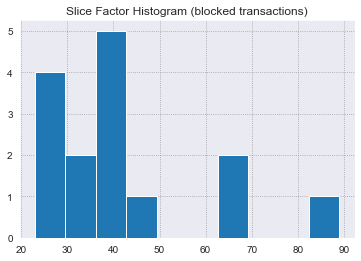

In [75]:
ax = swaps1_df[swaps1_df.status=='BLOCKED_BY_VOLATILITY_MITIGATION'].slice_factor.hist()

ax.set_title('Slice Factor Histogram (blocked transactions)')

**The majority of the transactions blocked by the vm had a slice factor less than 50, meaning that the token_out amount would be less than 50% of the remaning reserves after the swap for them**

Text(0.5, 1.0, 'Slice Factor Curve Histogram (blocked transactions)')

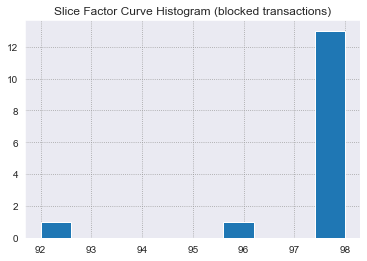

In [76]:
ax = swaps1_df[swaps1_df.status=='BLOCKED_BY_VOLATILITY_MITIGATION'].slice_factor_curve.hist()

ax.set_title('Slice Factor Curve Histogram (blocked transactions)')

In [77]:
import plotly.express as px

fig = px.histogram(swaps1_df, x="slice_factor", color="status",
                  title='Slice factor distribution (split by transaction status)').update_xaxes(categoryorder='total descending')
fig.show()

**It can be seen that all of the swaps with a slice_factor greater than 20 have been blocked**

In [78]:
import plotly.express as px

fig = px.histogram(swaps1_df[swaps1_df.slice_factor > 1], x="out_amount_diff", color="status",
                  title='Percentage difference of amount_out with oracle based amount_out, histogram').update_xaxes(categoryorder='total descending')
fig.show()

**The price difference with the one obtained from oracle for the majority of blocked transactions is greater by 30%, even though there are some cases where the difference is only about 10%**

Text(0.5, 1.0, 'Swaps slice_factor/out_amount_diff scatterplot (split by status)')

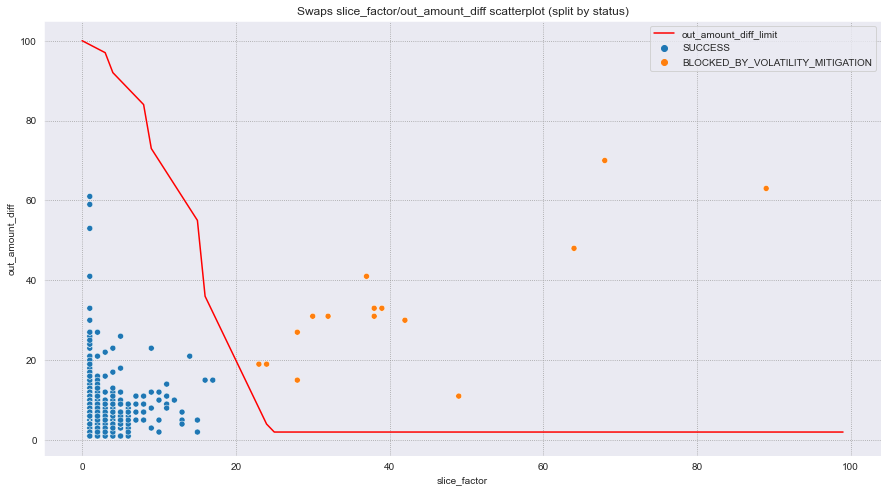

In [79]:
from scipy import stats

fig, ax = plt.subplots(figsize=(15, 8))
    
sns.scatterplot(data=swaps1_df[swaps1_df.mitigator_check_status == 'CHECKED'], x='slice_factor', y='out_amount_diff', hue='status')

slice_factor = np.arange(0, 100)
slice_factor_curve = slice_factor * np.sqrt(slice_factor).astype(int)
slice_factor_curve[slice_factor_curve > 98] = 98
out_amount_diff = (100 - slice_factor_curve)
sns.lineplot(x=slice_factor, y=out_amount_diff, color='red', label='out_amount_diff_limit')
ax.set_title('Swaps slice_factor/out_amount_diff scatterplot (split by status)')

**The out_amount_diff_limit border is not smooth, because the slice_factor_curve is computed according to the formula slice_factor * sqrt(slice_factor), where the sqrt(slice_factor) is rounded down in the original contract**

**It can be seen that the swaps are clustered into 3 groups. The swaps with a status SUCCESS are the most condensed ones. The border seems to separete the successful and blocked transactions pretty good. It can be observed that by varying the PRICE_TOLLERANCE_TRESHOLD by an amount less than 10, no effect would be obtained. It would require to decrease this number by more than 10 in order to change the distribution of successful/blocked transaction**

Text(0, 0.5, 'Count')

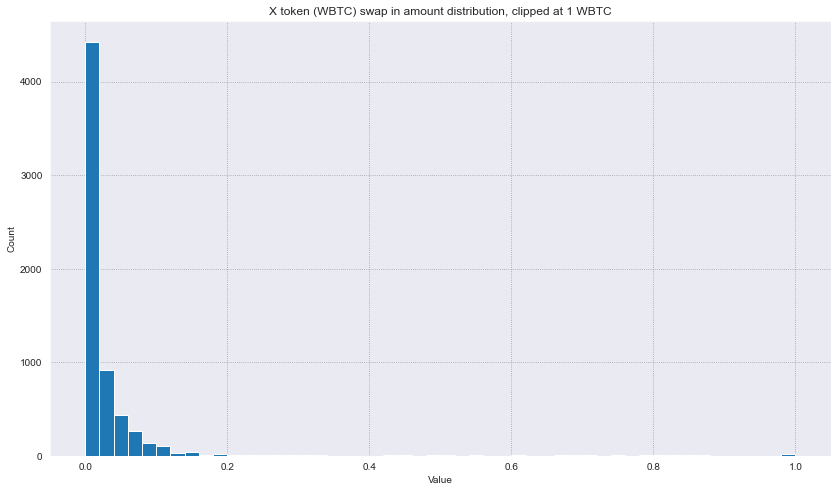

In [80]:
UPPER_LIMIT = 1

fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == X_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT

ax = amounts.hist(range=(0, UPPER_LIMIT), bins=50)

ax.set_title(f"X token ({X_NAME}) swap in amount distribution, clipped at {UPPER_LIMIT} {X_NAME}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

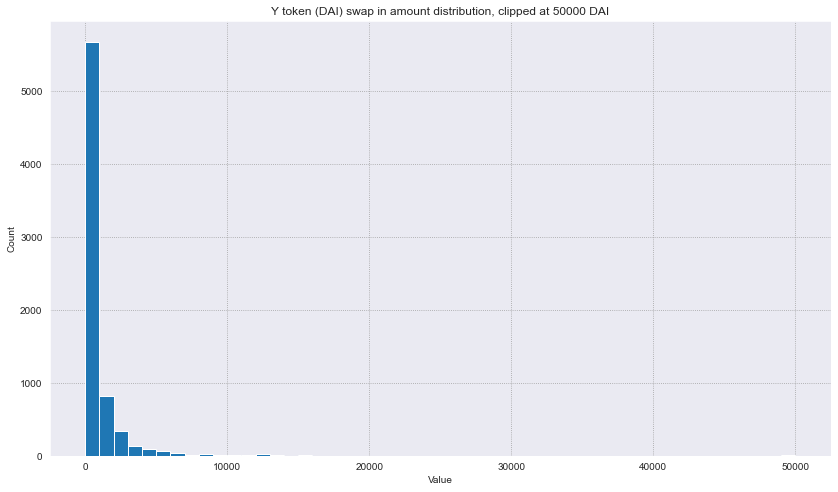

In [81]:
UPPER_LIMIT = 50000

fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == Y_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT

ax = amounts.hist(range=(0, UPPER_LIMIT), bins=50)

ax.set_title(f"Y token ({Y_NAME}) swap in amount distribution, clipped at {UPPER_LIMIT} {Y_NAME}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

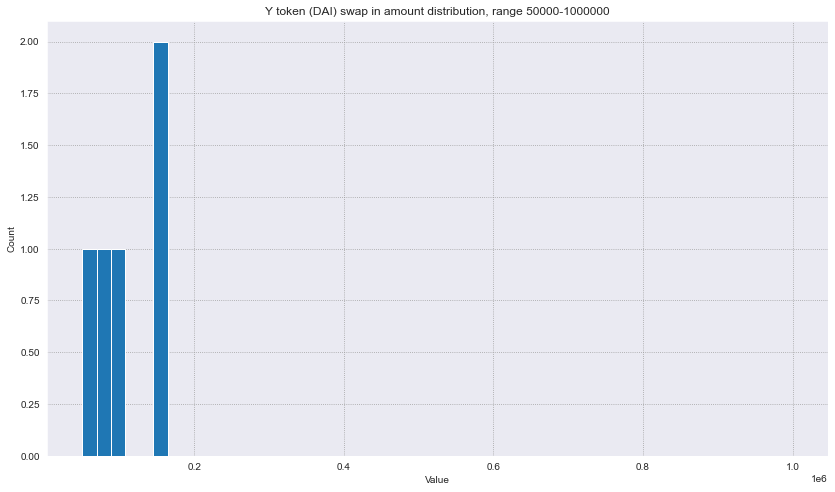

In [82]:
LOWER_LIMIT = 50000
UPPER_LIMIT = 1000000
fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == Y_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT
amounts = amounts[amounts > LOWER_LIMIT]
ax = amounts.hist(range=(LOWER_LIMIT, UPPER_LIMIT), bins=50)

ax.set_title(f"Y token ({Y_NAME}) swap in amount distribution, range {LOWER_LIMIT}-{UPPER_LIMIT}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

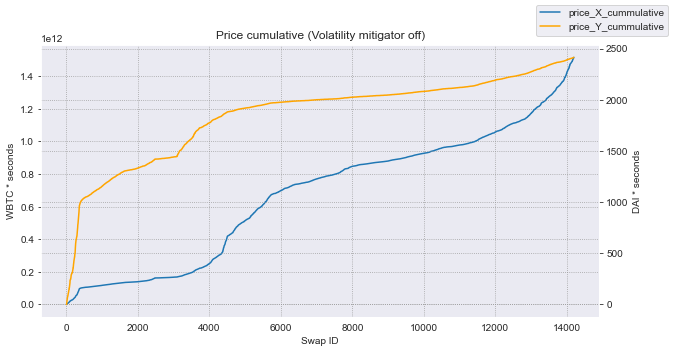

In [83]:

fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

ax.plot(swaps0_df.id, swaps0_df.price_X_cumulative,  label='price_X_cummulative')
ax2.plot(swaps1_df.id, swaps1_df.price_Y_cumulative,  label='price_Y_cummulative',  color='orange')

ax.set_title('Price cumulative (Volatility mitigator off)')
ax.set_xlabel('Swap ID')
ax.set_ylabel(X_NAME + ' * seconds') 
ax2.set_ylabel(Y_NAME + ' * seconds')

fig.legend()

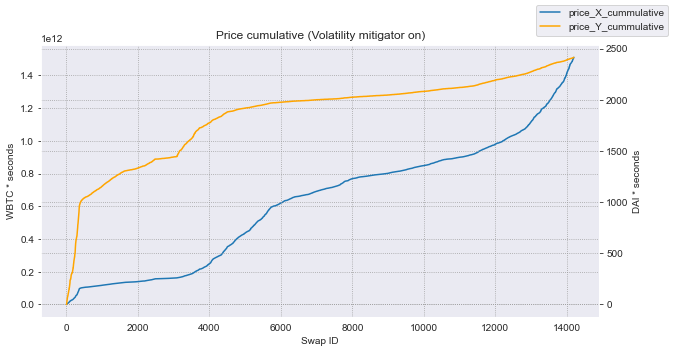

In [84]:

fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.id, swaps1_df.price_X_cumulative,  label='price_X_cummulative')
ax2.plot(swaps1_df.id, swaps1_df.price_Y_cumulative,  label='price_Y_cummulative',  color='orange')

ax.set_title('Price cumulative (Volatility mitigator on)')
ax.set_xlabel('Swap ID')
ax.set_ylabel(X_NAME + ' * seconds') 
ax2.set_ylabel(Y_NAME + ' * seconds')

fig.legend()

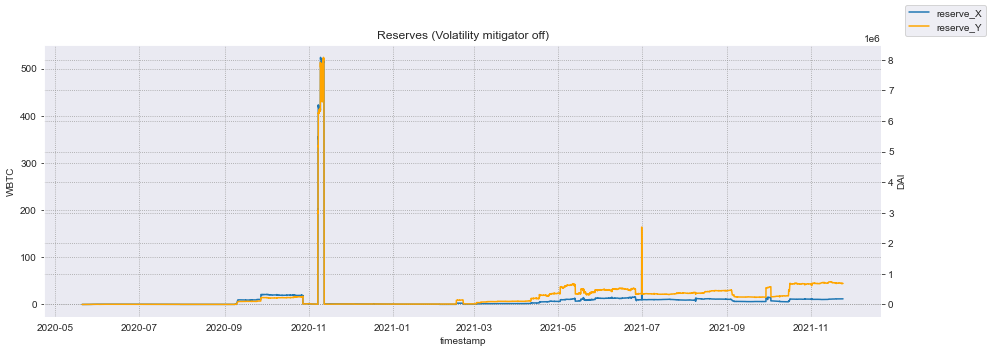

In [85]:
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps0_df.transaction_timestamp, swaps0_df.reserve_X, label='reserve_X')
ax2.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator off)')

fig.legend()

The spike in the reserves near 2021.07 is caused due to a liqiudity provision and extraction one hour later.

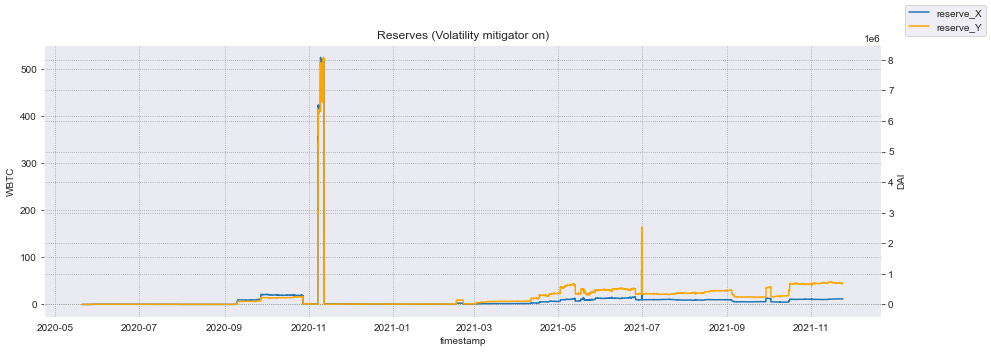

In [86]:
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_X, label='reserve_X')
ax2.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator on)')

fig.legend()

**The variation of reserves over time is very similar at the first glance with and without the volatility mitigator**

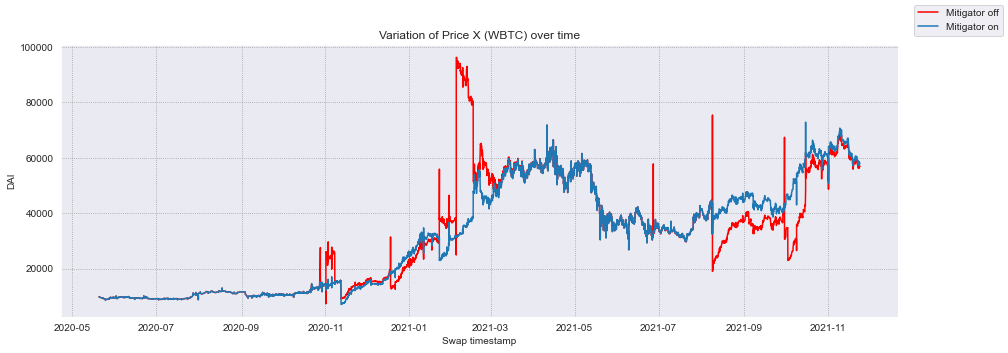

In [87]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=swaps0_df['transaction_timestamp'], y=swaps0_df['X_price'], linestyle='solid', marker=None, label='Mitigator off', color='red')
ax.plot_date(x=swaps1_df['transaction_timestamp'], y=swaps1_df['X_price'], linestyle='solid', marker=None, label='Mitigator on',)

ax.set_title(f'Variation of Price X ({X_NAME}) over time')
#ax.set_ylim(0, 0.1)
ax.set_xlabel('Swap timestamp')
ax.set_ylabel(Y_NAME)
fig.legend()

**It can be seen that there are no very big price variations in the simulation with the volatility mitigator turned on. The variation of price over time is much more smooth, due to blocking the transactions which cause a significant price impact**

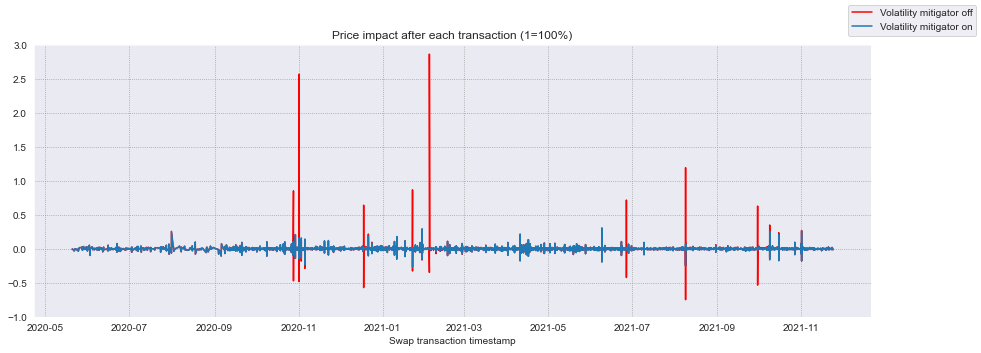

In [88]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(data=swaps0_df, x='transaction_timestamp', y='price_diff', linestyle='solid', color='red', marker=None, label='Volatility mitigator off')
ax.plot_date(data=swaps1_df, x='transaction_timestamp', y='price_diff', linestyle='solid', marker=None, label='Volatility mitigator on')

ax.set_ylim(-1, 3)
ax.set_xlabel('Swap transaction timestamp')
ax.set_title('Price impact after each transaction (1=100%)')
fig.legend()

**Almost all of the swaps with a significant price impact are blocked by the volatility mitigation mechanism**

Below is shown the information about the swaps with a price impact greater than 25%, not blocked by the volatility mitigation:

In [89]:
swaps1_df[swaps1_df.price_diff > 0.25]

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
257,293,DAI,WBTC,68.347541,0.0,0.006888,0.273390,CHECKED,0.006420,7.0,13.0,39.0,SUCCESS,424748.0,2020-07-31 15:05:56,2020-07-31 15:05:55,0xc946c23082b0acd1dcde07eb629485ffcd6253c683c9...,293,0.064177,562.788907,3.611790e+01,58339630585,667,True,0.057289,630.863058,3.614139e+01,58339762126,667,True,11011.978558,0.255731
4158,4311,DAI,WBTC,1500.000000,0.0,0.046029,6.000000,CHECKED,0.056833,21.0,14.0,42.0,SUCCESS,1473384.0,2021-01-29 16:24:56,2021-01-29 16:24:45,0xe4fe225e62faa0e030020ffffa5f8f8292ffe0be2094...,4311,0.380314,10784.789321,4.101607e+03,300573263218,1835,True,0.334285,12278.789321,4.104615e+03,300889308571,1836,True,36731.499607,0.295297
9680,9921,DAI,WBTC,60088.860940,0.0,1.943971,240.355444,CHECKED,1.835808,5.0,15.0,45.0,SUCCESS,2225278.0,2021-06-09 05:18:26,2021-06-09 05:18:18,0xa3b26dbc559f4da252b7997d358e59591f13fe74ea6e...,9921,15.576489,417172.377957,6.498081e+06,845786001343,2080,True,13.632518,477020.883453,6.502996e+06,845786001343,2080,True,34991.398347,0.306518
13269,13584,DAI,WBTC,30546.467448,0.0,0.626126,122.185870,CHECKED,0.592845,5.0,13.0,39.0,SUCCESS,2927492.0,2021-10-09 03:11:56,2021-10-09 03:11:56,0x6f0bb327ba54caa2f970daccf09930c9ec7229801972...,13584,5.699174,245021.124699,1.396418e+06,1264431218762,2349,True,5.073048,275445.406278,1.397348e+06,1264431218762,2349,True,54295.841017,0.262917
13633,13954,DAI,WBTC,76016.619296,0.0,1.320259,304.066477,CHECKED,1.258711,4.0,13.0,39.0,SUCCESS,3060963.0,2021-11-01 07:19:41,2021-11-01 07:19:28,0x204a15ee51fdf41cef4cecdacb1bbc5f8dd5b11b63b1...,13954,12.046588,611414.284377,7.365456e+06,1384667599021,2382,True,10.726329,687126.837195,7.370349e+06,1384667599021,2382,True,64059.832282,0.262160
